Loaded points:
 H: lat=29.995127, lon=31.684628
 DT: lat=30.000418, lon=31.739608
 GR: lat=30.011344, lon=31.747827
 R2: lat=30.030388, lon=31.669231
 R3_2: lat=30.030941, lon=31.688371
 IT: lat=30.012856, lon=31.693812


/tmp/ipython-input-2874722104.py:35: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
/usr/local/lib/python3.12/dist-packages/osmnx/routing.py:297: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  edges[["highway", "speed_kph"]].set_index("highway").iloc[:, 0].fillna(hwy_speed_avg)



=== Cost Matrix (km, road distances, strongly connected) ===
           H      DT      GR     R2    R3_2      IT
H      0.000   9.018   9.883  8.795  10.852   9.873
DT    13.440   0.000   2.666  9.885   8.708   9.264
GR    13.094   0.967   0.000  9.539   8.362   8.919
R2    10.439  14.887  14.144  0.000  10.514  11.511
R3_2   7.046   9.836   9.092  3.491   0.000   6.461
IT     6.948   7.838   8.703  4.718   6.775   0.000


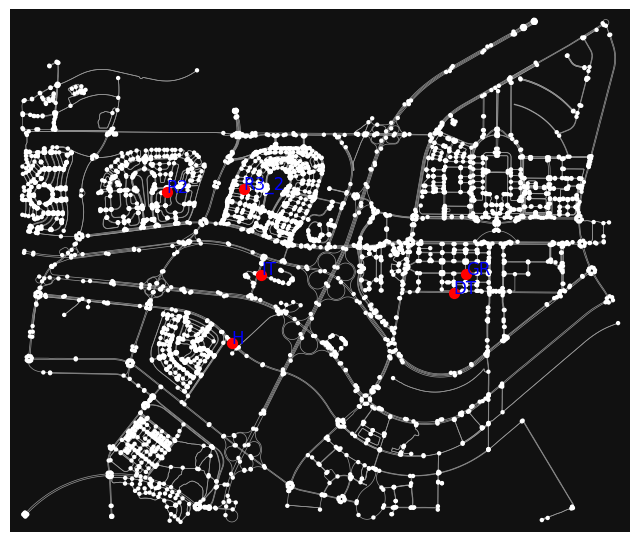

In [18]:
# --- Install dependencies (if not already installed) ---
# !pip -q install osmnx==1.9.2 networkx==3.2.1 folium==0.16.0 pandas==2.2.2 matplotlib==3.8.3

import json, math
import networkx as nx
import osmnx as ox
import folium, pandas as pd
import matplotlib.pyplot as plt

ox.settings.log_console = False
ox.settings.use_cache = True

# --- 1) Load coordinates from JSON ---
with open("/content/OptimizationProblemData.json","r",encoding="utf-8") as f:
    data = json.load(f)

hospital = data["locations"]["hospital"]["coordinates"]
patients = data["locations"]["patients"]

labels = ["H"] + [p["id"] for p in patients]
coords = [(hospital["latitude"], hospital["longitude"])] + [
    (p["coordinates"]["latitude"], p["coordinates"]["longitude"]) for p in patients
]

print("Loaded points:")
for i,(lat,lon) in enumerate(coords):
    print(f" {labels[i]}: lat={lat:.6f}, lon={lon:.6f}")

# --- 2) Build OSM road graph ---
lats = [lat for lat,lon in coords]
lons = [lon for lat,lon in coords]
north, south = max(lats)+0.04, min(lats)-0.04
east, west  = max(lons)+0.04, min(lons)-0.04

G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
G = ox.add_edge_speeds(G, fallback=80)       # default 50 km/h if missing
G = ox.add_edge_travel_times(G)              # travel time in seconds

# --- 3) Keep only the largest strongly connected component ---
largest_cc = max(nx.strongly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# --- 4) Resnap hospital + patients to nearest node in main network ---
node_ids = [ox.nearest_nodes(G, lon, lat) for lat,lon in coords]

# --- 5) Build cost matrix with Dijkstra (road km) ---
N = len(node_ids)
C = [[0.0]*N for _ in range(N)]
for i,u in enumerate(node_ids):
    lengths = nx.single_source_dijkstra_path_length(G, u, weight="length")
    for j,v in enumerate(node_ids):
        if i != j:
            C[i][j] = lengths[v]/1000.0  # km

# --- 6) Print clean matrix ---
df = pd.DataFrame(C, index=labels, columns=labels)
print("\n=== Cost Matrix (km, road distances, strongly connected) ===")
print(df.round(3))

# --- 7a) Static plot with graph + labeled points ---
fig, ax = ox.plot_graph(G, node_size=10, edge_linewidth=0.5, show=False, close=False)
x = [G.nodes[n]['x'] for n in node_ids]
y = [G.nodes[n]['y'] for n in node_ids]
ax.scatter(x, y, c="red", s=50, zorder=3)
for i,(xx,yy) in enumerate(zip(x,y)):
    ax.text(xx, yy, labels[i], fontsize=12, color="blue")
plt.show()

# --- 7b) Interactive folium map ---
lat0, lon0 = coords[0]
m = folium.Map(location=[lat0, lon0], zoom_start=13, tiles="cartodbpositron")

# hospital
folium.Marker([coords[0][0], coords[0][1]],
              tooltip=f"H: Hospital",
              icon=folium.Icon(color="red", icon="hospital-o", prefix="fa")).add_to(m)

# patients
for i in range(1,len(coords)):
    folium.Marker([coords[i][0], coords[i][1]],
                  tooltip=f"{labels[i]}",
                  icon=folium.Icon(color="blue", icon="user", prefix="fa")).add_to(m)

m



Abstract matrix graph: 6 nodes, 30 edges


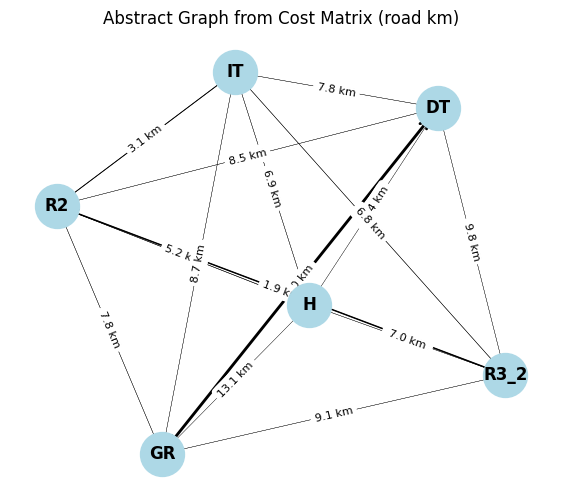

In [23]:
# --- 8) Model the cost matrix as its own abstract graph ---
M = nx.DiGraph()  # directed, since distances may be asymmetric
for i, src in enumerate(labels):
    for j, dst in enumerate(labels):
        if i != j:
            M.add_edge(src, dst, weight=C[i][j])

# Quick info
print(f"\nAbstract matrix graph: {M.number_of_nodes()} nodes, {M.number_of_edges()} edges")

# --- Plot the matrix graph ---
pos = nx.spring_layout(M, seed=42, weight="weight")  # layout, edges closer if shorter
plt.figure(figsize=(7,6))
nx.draw_networkx_nodes(M, pos, node_color="lightblue", node_size=1000)
nx.draw_networkx_labels(M, pos, font_size=12, font_weight="bold")

# edge widths scale with distance
edges = M.edges(data=True)
nx.draw_networkx_edges(M, pos, arrowstyle="->", arrowsize=15,
                       width=[2.0/max(0.1, d['weight']) for (_,_,d) in edges])

# edge labels = distance in km
edge_labels = {(u,v): f"{d['weight']:.1f} km" for u,v,d in edges}
nx.draw_networkx_edge_labels(M, pos, edge_labels=edge_labels, font_size=8)

plt.title("Abstract Graph from Cost Matrix (road km)")
plt.axis("off")
plt.show()


In [24]:
import itertools as it

# --- Helper: cost of a trip (hospital -> patients -> hospital) ---
def trip_cost(order, C):
    if not order:
        return 0.0
    cost = C[0][order[0]]  # H -> first
    for a, b in zip(order, order[1:]):
        cost += C[a][b]     # between patients
    cost += C[order[-1]][0] # last -> H
    return cost

# --- Enumerate all {3,2} splits ---
P = list(range(1, len(labels)))  # patient indices (1..N)
candidates = []

for trip1_set in it.combinations(P, 3):  # choose 3 for trip 1
    trip2_set = tuple(sorted(set(P) - set(trip1_set)))

    # best order for trip1
    best1 = min(
        ((trip_cost(list(perm), C), perm) for perm in it.permutations(trip1_set)),
        key=lambda x: x[0]
    )
    # best order for trip2
    best2 = min(
        ((trip_cost(list(perm), C), perm) for perm in it.permutations(trip2_set)),
        key=lambda x: x[0]
    )

    total = best1[0] + best2[0]
    candidates.append({
        "trip1": best1[1], "trip1_cost": best1[0],
        "trip2": best2[1], "trip2_cost": best2[0],
        "total": total
    })

# --- Sort by total distance ---
candidates.sort(key=lambda d: d["total"])

# --- Pretty print ---
def fmt_trip(order):
    return "H → " + " → ".join(labels[i] for i in order) + " → H"

print("\n=== BRUTE FORCE OPTIMUM (3+2 split) ===")
best = candidates[0]
print(f"Trip 1: {fmt_trip(best['trip1'])} | {best['trip1_cost']:.2f} km")
print(f"Trip 2: {fmt_trip(best['trip2'])} | {best['trip2_cost']:.2f} km")
print(f"TOTAL : {best['total']:.2f} km")

# --- Optional: show top few candidates ---
import pandas as pd
df = pd.DataFrame([{
    "Trip 1": fmt_trip(c["trip1"]),
    "Trip 1 km": round(c["trip1_cost"],2),
    "Trip 2": fmt_trip(c["trip2"]),
    "Trip 2 km": round(c["trip2_cost"],2),
    "TOTAL km": round(c["total"],2)
} for c in candidates])
print("\nTop candidate routes:")
print(df.head())



=== BRUTE FORCE OPTIMUM (3+2 split) ===
Trip 1: H → GR → DT → R3_2 → H | 26.60 km
Trip 2: H → IT → R2 → H | 18.15 km
TOTAL : 44.75 km

Top candidate routes:
                   Trip 1  Trip 1 km             Trip 2  Trip 2 km  TOTAL km
0  H → GR → DT → R3_2 → H      26.60    H → IT → R2 → H      18.15     44.75
1    H → GR → DT → IT → H      27.06  H → R3_2 → R2 → H      17.90     44.96
2  H → IT → R3_2 → R2 → H      23.69    H → GR → DT → H      24.29     47.98
3    H → GR → DT → R2 → H      24.29  H → IT → R3_2 → H      23.69     47.98
4  H → DT → R3_2 → R2 → H      24.77    H → GR → IT → H      25.75     50.52


In [25]:
import random

# --- Randomized Nearest Neighbor Heuristic (with multiple runs) ---
def randomized_nearest_neighbor(C, labels, capacity=3, alpha=0.3):
    """
    Greedy nearest-neighbor, but with randomness:
    - At each step, instead of always picking the single nearest,
      pick randomly among the top-k nearest (controlled by alpha).
    """
    N = len(labels)
    unserved = set(range(1, N))
    trips = []

    while unserved:
        trip = []
        curr = 0
        while unserved and len(trip) < capacity:
            # sort unserved by distance
            candidates = sorted(unserved, key=lambda j: C[curr][j])
            k = max(1, int(len(candidates) * alpha))  # top fraction
            chosen = random.choice(candidates[:k])
            trip.append(chosen)
            unserved.remove(chosen)
            curr = chosen
        trips.append(trip)
    return trips

def solution_cost(trips, C):
    total = 0.0
    for trip in trips:
        total += trip_cost(trip, C)
    return total

# --- Run 1000 iterations ---
best_sol, best_cost = None, float("inf")
for _ in range(100000):
    trips = randomized_nearest_neighbor(C, labels, capacity=3, alpha=0.4)
    total = solution_cost(trips, C)
    if total < best_cost:
        best_cost, best_sol = total, trips

# --- Print best solution ---
print("\n=== Best Solution from 1000 Randomized NN runs ===")
for t, trip in enumerate(best_sol, 1):
    cost = trip_cost(trip, C)
    route_str = "H → " + " → ".join(labels[i] for i in trip) + " → H"
    print(f"Trip {t}: {route_str} | {cost:.2f} km")
print(f"TOTAL : {best_cost:.2f} km")



=== Best Solution from 1000 Randomized NN runs ===
Trip 1: H → DT → GR → R2 → H | 24.78 km
Trip 2: H → IT → R3_2 → H | 23.69 km
TOTAL : 48.47 km


In [27]:
# --- Install dependencies if needed ---
# !pip -q install osmnx==1.9.2 networkx==3.2.1 folium==0.16.0 pandas==2.2.2 matplotlib==3.8.3

import json, itertools as it
import networkx as nx
import osmnx as ox
import folium, pandas as pd
import matplotlib.pyplot as plt

ox.settings.log_console = False
ox.settings.use_cache = True

# --- 1) Load coordinates from JSON ---
with open("/content/OptimizationProblemData.json","r",encoding="utf-8") as f:
    data = json.load(f)

hospital = data["locations"]["hospital"]["coordinates"]
patients = data["locations"]["patients"]

labels = ["H"] + [p["id"] for p in patients]
coords = [(hospital["latitude"], hospital["longitude"])] + [
    (p["coordinates"]["latitude"], p["coordinates"]["longitude"]) for p in patients
]

print("Loaded points:")
for i,(lat,lon) in enumerate(coords):
    print(f" {labels[i]}: lat={lat:.6f}, lon={lon:.6f}")

# --- 2) Build OSM road graph by distance from hospital ---
dist_m = 10000   # radius in meters (e.g. 10 km). Increase this for a bigger map
center_point = (hospital["latitude"], hospital["longitude"])

G = ox.graph_from_point(center_point, dist=dist_m, network_type="drive")
G = ox.add_edge_speeds(G, fallback=50)       # default speeds if missing
G = ox.add_edge_travel_times(G)              # add travel times

# --- 3) Keep only largest strongly connected component ---
largest_cc = max(nx.strongly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# --- 4) Snap hospital + patients to nearest node ---
node_ids = [ox.nearest_nodes(G, lon, lat) for lat,lon in coords]

# --- 5) Compute cost matrix ---
N = len(node_ids)
C = [[0.0]*N for _ in range(N)]
for i,u in enumerate(node_ids):
    lengths = nx.single_source_dijkstra_path_length(G, u, weight="length")
    for j,v in enumerate(node_ids):
        if i != j:
            C[i][j] = lengths[v]/1000.0  # km

df = pd.DataFrame(C, index=labels, columns=labels)
print("\n=== Cost Matrix (km, road distances) ===")
print(df.round(3))

# --- 6) Brute force optimum (3+2 split) ---
def trip_cost(order, C):
    if not order: return 0.0
    cost = C[0][order[0]]
    for a,b in zip(order, order[1:]):
        cost += C[a][b]
    cost += C[order[-1]][0]
    return cost

candidates = []
P = list(range(1, N))  # patient indices
for trip1_set in it.combinations(P, 3):
    trip2_set = tuple(sorted(set(P)-set(trip1_set)))
    best1 = min(((trip_cost(list(perm),C), perm) for perm in it.permutations(trip1_set)), key=lambda x:x[0])
    best2 = min(((trip_cost(list(perm),C), perm) for perm in it.permutations(trip2_set)), key=lambda x:x[0])
    total = best1[0] + best2[0]
    candidates.append({"trip1":best1[1],"trip2":best2[1],"total":total,"c1":best1[0],"c2":best2[0]})

candidates.sort(key=lambda d:d["total"])
best = candidates[0]
print("\n=== BRUTE FORCE OPTIMUM ===")
print("Trip 1:", "H → " + " → ".join(labels[i] for i in best["trip1"]) + " → H", "|", f"{best['c1']:.2f} km")
print("Trip 2:", "H → " + " → ".join(labels[i] for i in best["trip2"]) + " → H", "|", f"{best['c2']:.2f} km")
print("TOTAL :", f"{best['total']:.2f} km")

# --- 7) Build real road paths for those trips ---
def build_route_nodes(order):
    segs = [(0, order[0])] + list(zip(order, order[1:])) + [(order[-1], 0)]
    full_nodes = []
    for (a,b) in segs:
        seg = nx.shortest_path(G, node_ids[a], node_ids[b], weight="length")
        if full_nodes and full_nodes[-1] == seg[0]:
            full_nodes.extend(seg[1:])
        else:
            full_nodes.extend(seg)
    return full_nodes

def nodes_to_latlon(G, nodes):
    return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in nodes]

trip1_nodes = build_route_nodes(best["trip1"])
trip2_nodes = build_route_nodes(best["trip2"])
trip1_latlon = nodes_to_latlon(G, trip1_nodes)
trip2_latlon = nodes_to_latlon(G, trip2_nodes)

# --- 8) Folium map: raw coords + snapped nodes + trips ---
lat0, lon0 = coords[0]
m = folium.Map(location=[lat0, lon0], zoom_start=12, tiles="cartodbpositron")

# Raw coords (problem input)
folium.Marker([coords[0][0], coords[0][1]], tooltip="Hospital (raw)",
              icon=folium.Icon(color="red", icon="hospital-o", prefix="fa")).add_to(m)
for i in range(1, len(coords)):
    folium.Marker([coords[i][0], coords[i][1]], tooltip=f"{labels[i]} (raw)",
                  icon=folium.Icon(color="blue", icon="user", prefix="fa")).add_to(m)

# Snapped nodes (to prove map-matching)
for i, n in enumerate(node_ids):
    lat, lon = G.nodes[n]['y'], G.nodes[n]['x']
    folium.CircleMarker([lat, lon], radius=5, color="green", fill=True,
                        fill_opacity=1.0, tooltip=f"{labels[i]} snapped").add_to(m)

# Polylines for trips
folium.PolyLine(trip1_latlon, color="red", weight=6, opacity=0.8, tooltip="Trip 1").add_to(m)
folium.PolyLine(trip2_latlon, color="green", weight=6, opacity=0.8, tooltip="Trip 2").add_to(m)

m


Loaded points:
 H: lat=29.995127, lon=31.684628
 DT: lat=30.000418, lon=31.739608
 GR: lat=30.011344, lon=31.747827
 R2: lat=30.030388, lon=31.669231
 R3_2: lat=30.030941, lon=31.688371
 IT: lat=30.012856, lon=31.693812

=== Cost Matrix (km, road distances) ===
           H      DT      GR     R2    R3_2      IT
H      0.000   9.018   9.883  8.795  10.852   9.873
DT    13.440   0.000   2.666  9.885   8.708   9.264
GR    13.094   0.967   0.000  9.539   8.362   8.919
R2    10.439  14.887  14.144  0.000  10.514  11.511
R3_2   7.046   9.836   9.092  3.491   0.000   6.461
IT     6.948   7.838   8.703  4.718   6.775   0.000

=== BRUTE FORCE OPTIMUM ===
Trip 1: H → GR → DT → R3_2 → H | 26.60 km
Trip 2: H → IT → R2 → H | 25.03 km
TOTAL : 51.63 km
